# ***Talento B - Reto 3***

# ***Desarrollado por Geoffrey Esteban Pasaje Vidal***

# **Modelo de clasificación (clustering) en subtipologías basadas en similitudes**

Este reto lo abordaremos bajo la metodología CRISP-DM (Cross Industry Standard Process for Data Mining) para desarrollar un modelo de clasificación en subtipología bajo el enfoque no supervisado

## **1. Entendimiento del negocio**

**Contexto del Problema**

* El caso se desarrolla en el sector financiero, específicamente en la gestión de clientes de una institución bancaria.

* **Problema principal:** Los clientes generan notas (quejas o solicitudes) relacionadas con tarjetas de crédito. Estas notas no están organizadas ni clasificadas de manera estructurada, lo que dificulta a los investigadores identificar de manera eficiente el tema central de cada nota para ofrecer una respuesta rápida y adecuada.


**Objetivo general.**

* Diseñar un modelo que clasifique automáticamente las notas de los clientes en subtipologías bien definidas, facilitando el trabajo de los investigadores para responder a las solicitudes de manera más rápida y precisa.


**Objetivos específicos.**

* Agrupación en subtipologías:
  * Identificar patrones comunes en las notas y asignarlas a grupos (subtipologías) que reflejen temas específicos.
  * Cada subtipología debe ser descriptiva y permitir al investigador saber cómo proceder.

* Explicación de subtipologías:
  * Caracterizar claramente qué identifica a cada grupo (palabras clave, temas centrales, etc.).
  * Mostrar cómo se relacionan las notas dentro de un mismo grupo y entre diferentes grupos.

* Automatización del proceso:
  * Crear una solución escalable que pueda clasificar nuevas notas automáticamente.

* Propuesta de mejora:
  * Proponer acciones para optimizar las clasificaciones o incluso prevenir ciertas dolencias comunes.


**Restricciones técnicas.**

* Datos no etiquetados:

  * Las notas no tienen subtipologías predefinidas, por lo que el modelo debe trabajar con métodos no supervisados (clusterización).

  * Cantidad de datos limitada: Sólo tenemos 50 notas, lo que puede dificultar la generalización del modelo.

* Limitaciones del negocio:

  * El modelo debe ser interpretable, ya que los investigadores necesitan entender por qué una nota pertenece a un grupo específico.

  * Las subtipologías deben ser accionables, es decir, los grupos deben ser lo suficientemente específicos para permitir respuestas claras.

## **2. Comprensión de los Datos**

En esta etapa, nos enfocaremos en explorar, limpiar y preprocesar las 50 notas para preparar un dataset adecuado para la clusterización.

**1. Cargar los datos y instalar librerias**

Aquí, se importa la función pipeline de la librería transformers, que es parte de Hugging Face. Esta función se utiliza para cargar modelos preentrenados y realizar tareas de procesamiento de lenguaje natural (NLP), como clasificación, traducción, generación de texto, etc.

In [ ]:
from transformers import pipeline
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Cargar el modelo BART
normalizer = pipeline("text2text-generation", model="t5-small")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aquí se carga el modelo t5-small, que es un modelo de transformer preentrenado para tareas de generación de texto. El modelo se prepara para generar texto basado en un "prompt" que le pases. Aquí, text2text-generation indica que el modelo puede generar texto a partir de otro texto de entrada (en este caso, lo vamos a usar para "limpiar" las notas).


Aquí cargamos los datos que tenemos en nuestro drive personal

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Asignamos la ruta del archivo cargado desde el drive

In [ ]:
file_path = '/content/drive/MyDrive/Talento B/Prueba Tecnica Talento B IEO.xlsx'

Cargamos el archivo con pandas

In [ ]:
import pandas as pd

data = pd.read_excel(file_path)
print(data.head())

     Radicado                                               Nota
0  8015906864  MDZAMBRABuenas tardes  El cliente se comunica ...
1  8015906033  NATANBED Buenos dias, se comunica la cliente, ...
2  8015905224  YSALOMON Buenos Dias Linea Especializada Queja...
3  8015905636  VCOLORADBuen dia Se comunica la Sra. cliente m...
4  8015930094  DAFZAP Buen dia Se contacta el senor cliente i...


**2. Obtener información de los datos cargados**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Radicado  50 non-null     int64 
 1   Nota      50 non-null     object
dtypes: int64(1), object(1)
memory usage: 928.0+ bytes


Visualizamos que son 2 columnas y 50 entradas, con el tipo de dato int64 para la columna 'radicado', y object para la columna 'nota'

**3. Prelimpieza de los datos**

Eliminar datos duplicados

In [ ]:
data = data.drop_duplicates(subset='Nota')

Revisar y manejar valores nulos

In [ ]:
# Identificar nulos
print(data.isnull().sum())

# Eliminar filas con notas nulas
data = data.dropna(subset=['Nota'])

Radicado    0
Nota        0
dtype: int64


## **3. Preparación de los Datos**


### **3.1. Elimina caracteres especiales y normaliza el texto:**

Esta función tiene como objetivo limpiar y normalizar el texto de las notas, eliminando caracteres no deseados (como puntuación y números), palabras comunes y términos irrelevantes, y convirtiendo el texto a minúsculas. Todo esto se hace para preparar el texto de manera más adecuada para su análisis o procesamiento posterior.

In [ ]:
# Función para limpiar texto
def limpiar_texto(texto):
    # Definir stopwords en español
    stop_words = set(stopwords.words('spanish'))

    # Eliminar caracteres no deseados como puntuación, números y símbolos
    texto = ''.join([c for c in texto if c not in string.punctuation and not c.isdigit()])

    # Convertir texto a minúsculas
    texto = texto.lower()

    # Eliminar palabras comunes
    texto = ' '.join([palabra for palabra in texto.split() if palabra not in stop_words])

    # Eliminar términos irrelevantes como "en", "a", "de", "que", etc.
    texto = re.sub(r'\b(?:en|a|de|que|el|la|of|mas|cuanto|s|ap|buenas|hacer|va|d|los|las)\b', '', texto)

    # Eliminar espacios extra y dejar solo un espacio entre las palabras
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

# Limpiar las notas antes de pasarlas al modelo
data['Nota_Limpia'] = data['Nota'].apply(limpiar_texto)


Cómo habiamos mencionado anteriormente en esta función se utiliza el modelo t5-small para limpiar y normalizar las entradas de las notas de la base de datos:

**Entrada:** Recibe un texto (texto) que es la nota que quieres limpiar.

**Prompt:** Crea un "prompt" para el modelo de Hugging Face, pidiéndole que elimine nombres, saludos y términos irrelevantes, y que haga un resumen conciso del texto. Esto proporciona una indicación clara de lo que quieres que haga el modelo con el texto de entrada.

**Generación:** El modelo normalizer recibe este prompt y genera una respuesta basada en el texto que se le pasa.

**Resultado:** El resultado es un texto generado que contiene el texto limpiado (sin nombres, saludos o términos irrelevantes).

In [ ]:
def normalizar_texto_huggingface(texto):
    prompt = f"Elimina los nombres de personas y simbología: {texto}"
    result = normalizer(prompt, max_new_tokens=150)  # Solo max_new_tokens
    return result[0]['generated_text'].strip()

# Aplicar la normalización al texto
data['nota_normalizada'] = data['Nota_Limpia'].apply(normalizar_texto_huggingface)


Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


Verificamos aquí nuestra nota normalizada

In [ ]:
# Verificar el resultado
print(data[ 'nota_normalizada'])

0     acuerdo cobro diferido auna sola cuota aparte ...
1     ahora registra deuda dolares usd tenia conocim...
2     y simbologa: ysalomon buenos dias linea especi...
3     medio pago escenarios linea ahora vamos aplica...
4     registrar tdc garmin pay inicio ingresaba codi...
5     tarjetas credito american express mastercard i...
6     colocar reclamacion compra autorizaciones pend...
7     s corri intcorcoint intereses compr intcorcoin...
8     fecha emision fecha vencimiento exoneracion du...
9     a a a a a y simbologa: deplaza tardesel client...
10    a a a a a a pmarbole buen dia comunica cliente...
11    wperez cliente indica hace dos semanas realizo...
12    ej deuda tenia dolares ultimo pago fecha solic...
13    acuerdo transacciones hagan tdc encuentren aut...
14    a aclaracion reversiones abono ven reflejados ...
15    svp descripcion codigo fas cash avail categori...
16    acude modo solicitar cancelacion linea telefon...
17    agradecemos revision feliz diacarlos b. El

Volvemos y aplicamos otra limpieza manual para evitar los errores del modelo de procesamiento de lenguaje

Cómo vemos el modelo no es lo suficiente robusto y alucina, en esta caso vamos a usar simplemente la función manual de limpiar texto para evitar errores en la clasificacion

In [ ]:
# Limpiar las notas antes de pasarlas al modelo
data['Nota_Limpia'] = data['Nota_Limpia'].apply(limpiar_texto)

In [ ]:
# Verificar el resultado
print(data['Nota_Limpia'])

0     mdzambrabuenas tardes cliente comunica dia hoy...
1     natanbed buenos dias comunica cliente desea qu...
2     ysalomon buenos dias linea especializada queja...
3     vcoloradbuen dia comunica sra cliente molesta ...
4     dafzap buen dia contacta senor cliente indican...
5     msgiraldla clienta comunica encuentra disgusta...
6     dalmanzabuen dia cliente comunica quiere coloc...
7     hdrestre tardes comunica cliente solicitando a...
8     maromerbuenas tardes comunica cliente molesto ...
9     deplaza tardesel cliente comunica molesto debi...
10    pmarbole buen dia comunica cliente solicitando...
11    wperez cliente indica hace dos semanas realizo...
12    yevelez buen dia cliente indica realizo pago t...
13    kmcorrea buenos dias comunica cliente solicita...
14    anacaper hola noches cliente comunica desconoc...
15    mlizaraz tardes cliente comunica debidoa utili...
16    diegtorr buen dia adjunta carta cliente manifi...
17    carlbeta cordial saludo cliente preferenci

### **3.2. Representar el texto como vectores:**

Aquí usare TF-IDF para convertir el texto en una matriz numérica que puede ser procesada por el modelo K-Means.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convertir texto a representación numérica
vectorizer = TfidfVectorizer(max_features=500)  # Puedes ajustar el número de características
X = vectorizer.fit_transform(data['Nota_Limpia']).toarray()

# Mostrar las palabras clave seleccionadas
print(vectorizer.get_feature_names_out())

['abono' 'acceso' 'acerca' 'aclara' 'aclaracion' 'aclare' 'activ' 'activa'
 'actual' 'acude' 'acuerdo' 'ademas' 'adjunta' 'adjunto' 'afectacion'
 'agosto' 'agregue' 'ahora' 'ahorros' 'ajuste' 'algun' 'american' 'amex'
 'amparador' 'ampliacion' 'ano' 'ant' 'anterior' 'aparece' 'aparte'
 'aplicacion' 'aplico' 'aplsalfav' 'apple' 'aprobada' 'aproximadamente'
 'as' 'asemeja' 'asesor' 'asesora' 'asi' 'atencion' 'atendio' 'aumento'
 'aun' 'aut' 'auto' 'automatico' 'autorizacio' 'autorizaciones' 'av'
 'avail' 'avance' 'avianca' 'banco' 'bancolombia' 'black' 'bloqueada'
 'bloquean' 'bloqueo' 'buen' 'buenos' 'cajero' 'cali' 'canales'
 'cancelacion' 'cancelar' 'capital' 'cargar' 'cargo' 'cartera' 'cash'
 'caso' 'castig' 'castigdo' 'categoria' 'cc' 'centralizada' 'ciclo'
 'clasica' 'cliente' 'cobrando' 'cobro' 'cobros' 'cod' 'codigo' 'colocar'
 'comercial' 'comercio' 'comision' 'comnacional' 'compr' 'compra'
 'compras' 'comprende' 'comunica' 'comunicacion' 'comunicado' 'comunico'
 'conforme' 'con

## **4. Modelado**

### **4.2. Implementación y visualización del clustering usando KMeans**

Palabras clave seleccionadas:
['abono' 'acceso' 'acerca' 'aclara' 'aclaracion' 'aclare' 'activ' 'activa'
 'actual' 'acude' 'acuerdo' 'ademas' 'adjunta' 'adjunto' 'afectacion'
 'agosto' 'agregue' 'ahora' 'ahorros' 'ajuste' 'algun' 'american' 'amex'
 'amparador' 'ampliacion' 'ano' 'ant' 'anterior' 'aparece' 'aparte'
 'aplicacion' 'aplico' 'aplsalfav' 'apple' 'aprobada' 'aproximadamente'
 'as' 'asemeja' 'asesor' 'asesora' 'asi' 'atencion' 'atendio' 'aumento'
 'aun' 'aut' 'auto' 'automatico' 'autorizacio' 'autorizaciones' 'av'
 'avail' 'avance' 'avianca' 'banco' 'bancolombia' 'black' 'bloqueada'
 'bloquean' 'bloqueo' 'buen' 'buenos' 'cajero' 'cali' 'canales'
 'cancelacion' 'cancelar' 'capital' 'cargar' 'cargo' 'cartera' 'cash'
 'caso' 'castig' 'castigdo' 'categoria' 'cc' 'centralizada' 'ciclo'
 'clasica' 'cliente' 'cobrando' 'cobro' 'cobros' 'cod' 'codigo' 'colocar'
 'comercial' 'comercio' 'comision' 'comnacional' 'compr' 'compra'
 'compras' 'comprende' 'comunica' 'comunicacion' 'comunicad

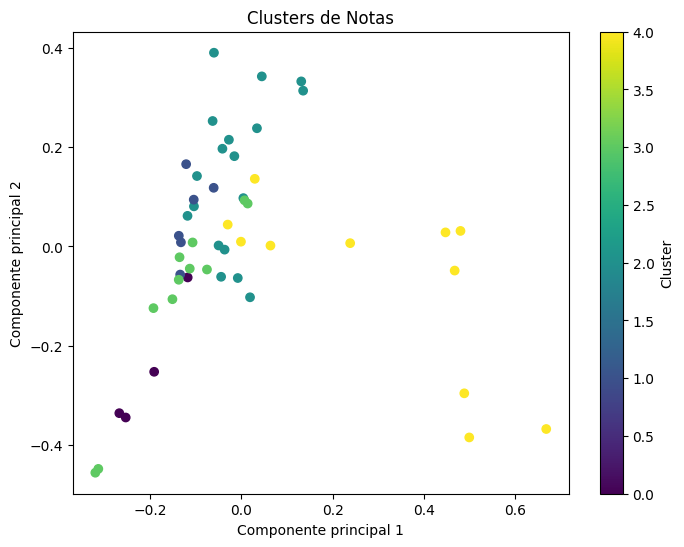

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convertir texto a representación numérica
vectorizer = TfidfVectorizer(max_features=500)  # Puedes ajustar el número de características
X = vectorizer.fit_transform(data['Nota_Limpia']).toarray()

# Mostrar las palabras clave seleccionadas
print("Palabras clave seleccionadas:")
print(vectorizer.get_feature_names_out())

# Aplicar K-Means
# Número de clusters que quieres
num_clusters = 5  # Ajusta este valor según tus necesidades
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Obtener los índices de los clusters asignados
data['Cluster'] = kmeans.labels_

# Mostrar los resultados
print(f"\nCentroides de los clusters:\n{kmeans.cluster_centers_}")
print(f"\nEtiquetas asignadas a las notas (Clusters):\n{data[['Nota_Limpia', 'Cluster']].head()}")

# Para visualizar los clusters (opcional), si tienes menos de 3 características puedes usar un gráfico 2D o 3D
# Reducir la dimensionalidad a 2D con PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Graficar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Clusters de Notas')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Cluster')
plt.show()


### **4.1 analisis de clústeres**

In [ ]:
import numpy as np

# Obtener las palabras clave de cada clúster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    palabras_indices = np.argsort(kmeans.cluster_centers_[i])[::-1][:10]
    palabras_clave = [vectorizer.get_feature_names_out()[index] for index in palabras_indices]
    print("Palabras clave:", palabras_clave)
    print("-" * 30)

Cluster 0:
Palabras clave: ['codigo', 'error', 'inscripcion', 'tardescliente', 'indica', 'permie', 'permite', 'inconveniente', 'vip', 'pass']
------------------------------
Cluster 1:
Palabras clave: ['cancelacion', 'deuda', 'abono', 'sido', 'aclaracion', 'cliente', 'cargo', 'tardes', 'dolares', 'reversiones']
------------------------------
Cluster 2:
Palabras clave: ['pago', 'valor', 'fecha', 'deuda', 'cliente', 'tarjeta', 'minimo', 'dolares', 'credito', 'dia']
------------------------------
Cluster 3:
Palabras clave: ['tdc', 'cliente', 'sistema', 'saber', 'indica', 'linea', 'proceso', 'apple', 'operativo', 'bloqueo']
------------------------------
Cluster 4:
Palabras clave: ['intereses', 'corri', 'corrientes', 'cuota', 'intcorcodif', 'cliente', 'tarjeta', 'pago', 'banco', 'dian']
------------------------------


# **5. Evaluación del modelo:**


Guardar los datos con los clústeres asignados para análisis

In [ ]:
# Exportar a un archivo CSV
data.to_csv('datos_clusterizados.csv', index=False)

# **6. Implementación y Deployment del Modelo:**



Después de realizar la clusterización y exportar los resultados, el siguiente paso en el flujo de trabajo implica automatizar el proceso y hacer el deployment para que el modelo sea accesible de manera continua, eficiente y escalable

**1.  Crear una API REST (Usando FastAPI o Flask):**

Esta opción permite exponer el modelo como un servicio web que pueda recibir nuevos datos, procesarlos y devolver los resultados de la clasificación (o cualquier otra predicción) de manera automática.

FastAPI es se nos presenta como una excelente opción para hacer esto de manera rápida y eficiente, especialmente con modelos de Machine Learning.